In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
import matplotlib.pyplot as plt
from pytorch_lightning.utilities import move_data_to_device

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator
from case_studies.dc2_mdt.utils.likelihood_fn import rml_likelihood

In [3]:
image_size = 4
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size * max_objects, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2 + 1, hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

        self.vmap_timestep_embed = torch.vmap(self.timestep_embed.forward, in_dims=1, out_dims=1, randomness="same")
        self.vmap_input_embed = torch.vmap(self.input_embed.forward, in_dims=1, out_dims=1, randomness="same")
        self.vmap_layers = torch.vmap(self.layers.forward, in_dims=1, out_dims=1, randomness="same")

    def forward(self, x, t, image, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.vmap_timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m (d w)")
            )  # (b, m, hidden)
            embed_xt = self.vmap_input_embed(x.flatten(2))  # (b, m, hidden)
            embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
            embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
            out = self.vmap_layers(
                torch.cat([embed_xt + embed_t, embed_image, epsilon], dim=-1)
            )
            return out.view(x.shape)
        t = t.clone()
        image = image.clone()
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image, epsilon], dim=-1)
        )
        return out.view(x.shape)

In [5]:
device = torch.device("cuda:4")
batch_size = 1024
val_batch_size = 30_000
training_time_steps = 1000
training_iters = 5000
val_iters = 5000
ddim_steps = 5
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [6]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=64,
                                  lambda_=1.0,
                                  beta=0.5)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 flux_alpha=10.0,
                                 flux_beta=0.01).to(device=device)

In [7]:
my_net = FourierMLP(data_shape=[1,], 
                    num_layers=8, 
                    hidden_ch=256).to(device=device)
# my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [8]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [9]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [10]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    input_image = catalog["images"].permute([0, 3, 1, 2])  # (b, m, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    train_loss_args = {
        "model": my_net,
        "x_start": encode_flux(target_fluxes),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

 10%|█         | 503/5000 [00:30<04:50, 15.49it/s]

[500/5000] loss: 1.012e-01


 20%|██        | 1003/5000 [01:05<04:46, 13.94it/s]

[1000/5000] loss: 9.781e-02


 30%|███       | 1503/5000 [01:42<04:25, 13.17it/s]

[1500/5000] loss: 9.740e-02


 40%|████      | 2003/5000 [02:21<03:56, 12.66it/s]

[2000/5000] loss: 8.145e-02


 50%|█████     | 2503/5000 [03:00<03:17, 12.64it/s]

[2500/5000] loss: 7.333e-02


 60%|██████    | 3001/5000 [03:40<02:40, 12.43it/s]

[3000/5000] loss: 7.111e-02


 70%|███████   | 3503/5000 [04:21<02:01, 12.35it/s]

[3500/5000] loss: 7.372e-02


 80%|████████  | 4003/5000 [05:01<01:21, 12.30it/s]

[4000/5000] loss: 6.846e-02


 90%|█████████ | 4501/5000 [05:42<00:40, 12.27it/s]

[4500/5000] loss: 7.014e-02


100%|██████████| 5000/5000 [06:22<00:00, 13.06it/s]

[5000/5000] loss: 7.034e-02


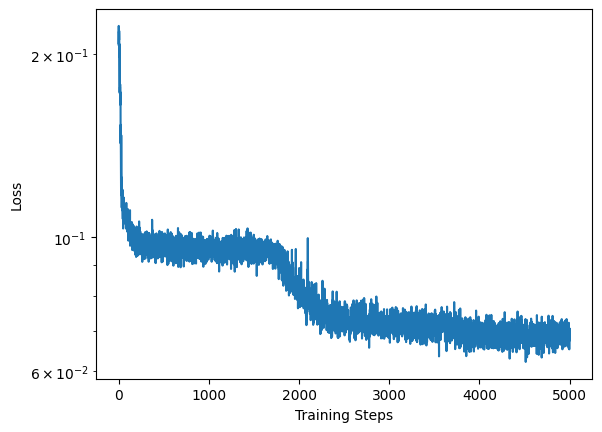

In [11]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [12]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed)
    for i in tqdm.tqdm(list(range(val_iters))):
        target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
        if val_true_fluxes is None:
            val_true_fluxes = target_fluxes
        else:
            assert torch.allclose(val_true_fluxes, target_fluxes)
        input_image = val_catalog["images"].permute([0, 3, 1, 2])
        match image_normalize_strategy:
            case "none":
                pass
            case "log":
                input_image = torch.log1p(input_image)
            case "linear_scale":
                input_image = input_image / 1000
            case _:
                raise NotImplementedError()
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (val_batch_size, 1),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_fluxes.append(decode_flux(sample).cpu())
val_est_fluxes = torch.stack(val_est_fluxes, dim=0)

100%|██████████| 5000/5000 [07:43<00:00, 10.78it/s]


In [13]:
val_true_fluxes = val_true_fluxes.cpu()

In [14]:
val_true_fluxes.shape

torch.Size([30000, 1])

In [15]:
val_est_fluxes.shape

torch.Size([5000, 30000, 1])

In [16]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(98411.7578)

In [17]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(192.4670)

In [18]:
# plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True, label="Est")
# plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True, label="True")
# plt.ylabel("Density")
# plt.xlabel("Flux")
# plt.legend()
# plt.show()

In [19]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])

In [20]:
actual_ci_cover = torch.cat([a.unsqueeze(0) for a in actual_ci_cover])

In [21]:
actual_ci_cover

tensor([0.0272, 0.0735, 0.1380, 0.1962, 0.2521, 0.3014, 0.3486, 0.3985, 0.4458,
        0.4957, 0.5428, 0.5919, 0.6422, 0.6910, 0.7406, 0.7905, 0.8397, 0.8911,
        0.9412])

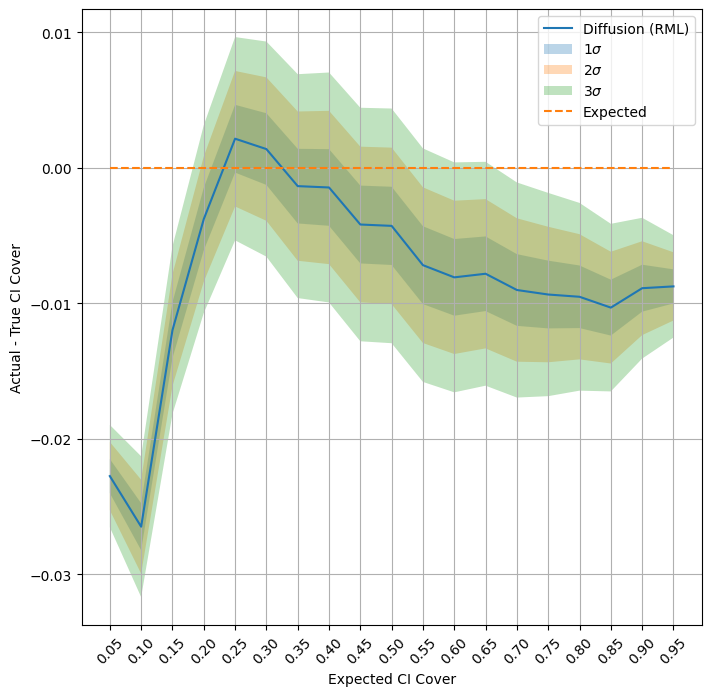

In [22]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
ci_sigma = (ci_cover * (1 - ci_cover) / val_batch_size) ** 0.5
plt.plot(ci_cover, a_m_c, label="Diffusion (RML)")
plt.fill_between(ci_cover, a_m_c - ci_sigma, a_m_c + ci_sigma, alpha=0.3, label=r"$1\sigma$")
plt.fill_between(ci_cover, a_m_c - 2 * ci_sigma, a_m_c + 2 * ci_sigma, alpha=0.3, label=r"$2\sigma$")
plt.fill_between(ci_cover, a_m_c - 3 * ci_sigma, a_m_c + 3 * ci_sigma, alpha=0.3, label=r"$3\sigma$")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()

In [23]:
val_catalog = move_data_to_device(val_catalog, "cpu")

In [24]:
true_post_dist = image_simulator.post_dist(val_catalog)

In [25]:
true_post_dist

MixtureSameFamily(
  Categorical(probs: torch.Size([30000, 2]), logits: torch.Size([30000, 2])),
  Gamma(concentration: torch.Size([30000, 2]), rate: torch.Size([30000, 2])))

In [26]:
(-1 * true_post_dist.log_prob(val_est_fluxes.squeeze(-1))).mean()

tensor(5.8885)

In [27]:
(-1 * true_post_dist.log_prob(true_post_dist.sample((val_iters, )))).mean()

tensor(5.4476)

In [28]:
def wasserstein_distance(est_samples: torch.Tensor, true_samples: torch.Tensor):
    assert est_samples.ndim == 2  # (val_iters, val_batch_size)
    assert est_samples.shape == true_samples.shape
    sorted_true_samples = torch.sort(true_samples, dim=0, descending=False)[0]
    sorted_est_samples = torch.sort(est_samples, dim=0, descending=False)[0]
    return torch.abs(sorted_est_samples - sorted_true_samples).mean(dim=0)  # (b, )

In [29]:
wasserstein_distance(val_est_fluxes.squeeze(-1), true_post_dist.sample((val_iters, )).cpu()).mean()

tensor(10.8980)

In [30]:
val_true_fluxes[0]

tensor([440.4596])

In [31]:
val_est_fluxes.shape

torch.Size([5000, 30000, 1])

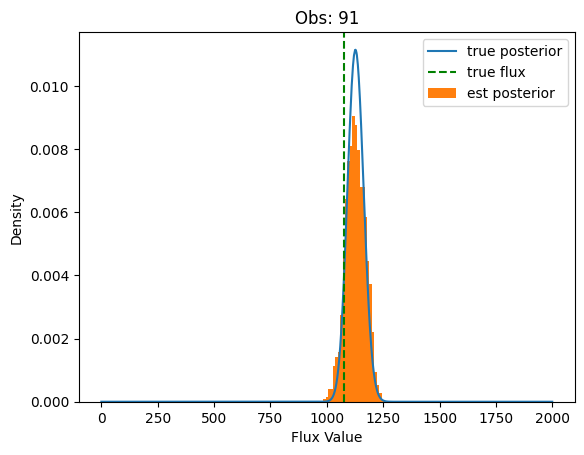

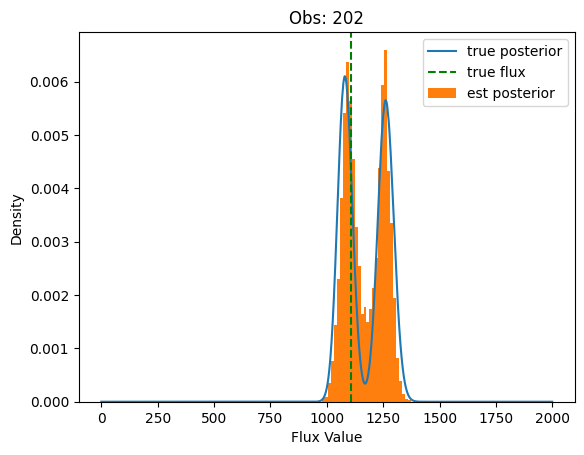

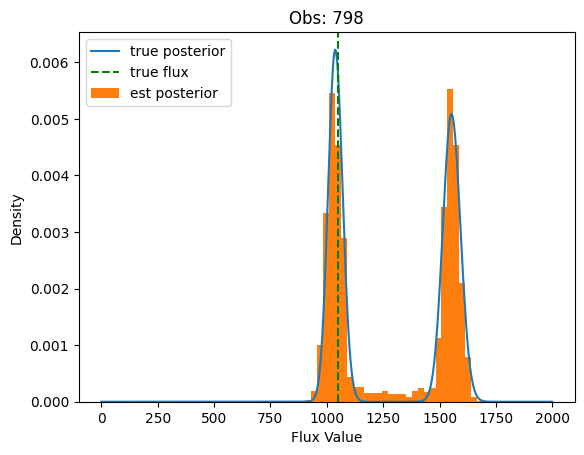

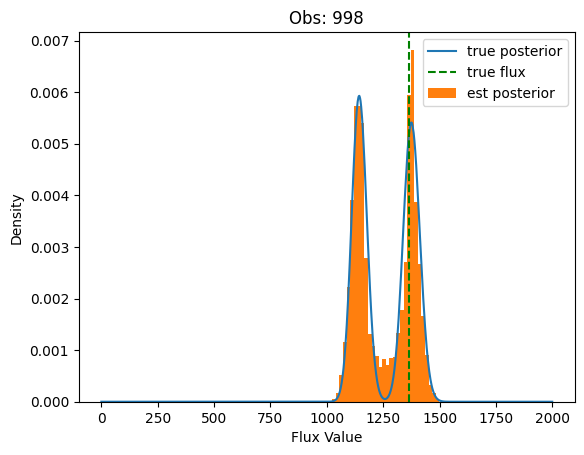

In [34]:
x = torch.linspace(0, 2000, 5000)
obs_index = [91, 202, 798, 998]
for i in obs_index:
    plt.plot(x, true_post_dist.log_prob(x.view(-1, 1))[:, i].exp().cpu(), label="true posterior")
    plt.axvline(x=val_true_fluxes[i].item(), color="green", linestyle="dashed", label="true flux")
    plt.hist(val_est_fluxes[:, i, 0].cpu(), density=True, bins=30, label="est posterior")
    plt.legend()
    plt.xlabel("Flux Value")
    plt.ylabel("Density")
    plt.title(f"Obs: {i}")
    plt.show()

## Likelihood

In [ ]:
input_image.shape

In [ ]:
# rml_fixed_noise = torch.randn_like(val_true_fluxes, device=device)
# x0_model_fn = lambda xt, t: my_net(x=xt, t=t, 
#                                    image=input_image, 
#                                    epsilon=rml_fixed_noise, 
#                                    is_training=False)

In [ ]:
x0_model_fn = lambda xt, t: my_net(x=xt, t=t, 
                                   image=input_image, 
                                   epsilon=torch.randn_like(xt), 
                                   is_training=False)

In [ ]:
nll, z, nfe = rml_likelihood(x0_model_fn, 
                            x0=encode_flux(val_true_fluxes.to(device=device)), 
                            num_timesteps=training_time_steps,
                            n=64)

In [ ]:
z.mean(), z.std()

In [ ]:
nfe

In [ ]:
nll.shape

In [ ]:
nll.median(), nll.mean()

In [ ]:
plt.scatter(val_true_fluxes.flatten().cpu(), nll.cpu())
plt.yscale("log")
plt.ylabel("NLL")
plt.xlabel("True Flux")
plt.show()

In [ ]:
ori_nll = nll + 1 * np.log(1 / 1000)

In [ ]:
ori_nll.median(), ori_nll.mean()

In [ ]:
ori_nll.quantile(q=torch.tensor([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99], device=device))